In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import glob
import os
import scipy.stats
from matplotlib import cm
import seaborn as sns
import dask
import pickle
from datetime import datetime
import ast

In [2]:
models = [x.split('/')[-1] for x in glob.glob("/terra/data/cmip5/global/rcp85/*")]   

In [3]:
dic = pickle.load(open("monthly_tas_dic.p", "rb"))

In [4]:
for index in dic:
    date_string = str('1/'+str(dic[index].time[0].dt.month.values)+'/'+str(dic[index].time[0].dt.year.values))
    start = datetime.strptime(date_string, "%d/%m/%Y")
    x = pd.date_range(start, periods=len(dic[index].time), freq='M')
    dic[index]['time'] = x

In [5]:
rolled={}
for index in dic:
    rolled[index] = dic[index].load().rolling(time = 120, center = True).mean()
    
selled = {}
for index in dic:
    selled[index] = rolled[index].sel(time = slice('1979','2080'))

In [6]:
cmip = [model for model in models if model in dic.keys()] #this just exludes ERA5 and NOAA20CR

maximum=[]
minimum=[]

for i in range(len(selled['ACCESS1-0'])):
    vals = []
    for model in cmip:
        vals.append(selled[model].values[i])
    minimum.append(np.min(vals))
    maximum.append(np.max(vals))
    
    

cmip_range = xr.Dataset(dict(maximum = (["time"], maximum),minimum = (["time"], minimum)) ,coords=dict(time = selled[model].time))

In [7]:
results = pd.read_csv('../../scores/results.csv').set_index('Model')
results = [model for model in results.index if model in cmip]

maximum=[]
minimum=[]

for i in range(len(selled['ACCESS1-0'])):
    vals = []
    for model in results:
        vals.append(selled[model].values[i])
    minimum.append(np.min(vals))
    maximum.append(np.max(vals))
    
considered_range = xr.Dataset(dict(maximum = (["time"], maximum),minimum = (["time"], minimum)) ,coords=dict(time = selled[model].time))

In [8]:
col_dic = pickle.load(open('../../scores/col_dic.p','rb'))

In [9]:
file = open("../../genealogy/Knutti_colours_dict.txt", "r")
contents = file.read()
knutti_dic = ast.literal_eval(contents)
file.close()

In [10]:
familys = [['MIROC-ESM-CHEM'] , ['BNU-ESM'] , ['CNRM-CM5'] , ['IPSL-CM5A-MR','IPSL-CM5A-LR'] , ['GFDL-ESM2M','GFDL-ESM2G','GFDL-CM3'] , ['bcc-csm1-1-m','bcc-csm1-1'] , ['ACCESS1-0','ACCESS1-3'] , ['MRI-ESM1','MRI-CGCM3'], ['MIROC5']]

In [12]:
models = [model for model in selled if model in col_dic.keys()]

In [13]:
for fam in familys:
    fig,ax = plt.subplots(figsize=(16, 9))
    for model in models:
        selled[model].plot(color = col_dic[model] , linewidth = 1.5, alpha = 0.4)
    for model in fam:
        selled[model].plot(label = str(model) , color = col_dic[model] , linewidth = 4.5) 
        ax.annotate(xy=(pd.to_datetime('2080/12/30'),selled[model].dropna(dim='time').values[-1]), xytext=(3,0), textcoords='offset points', text=str(model), va='center',color = 'black')
    x = considered_range
    ax.fill_between(x.time, x.minimum,x.maximum, facecolor='cadetblue', alpha=0.8, label = 'Considered Ensemble')     
    for x in [-1,0,1,2,3,4, 5]:
        ax.axhline(x,color = 'cadetblue', alpha = 0.5)
    ax.set_ylim(-1,6)
    ax.set_xlim(pd.to_datetime('1970/01/01'), pd.to_datetime('2095/01/01'))
    #plt.legend(loc='upper left', fontsize = 'small')
    plt.ylabel('Temperature Anomaly (K)')
    plt.title(str(fam))
    plt.savefig('FAMILY_PLOTS/'+str(fam[0])+'.pdf')
    plt.close()

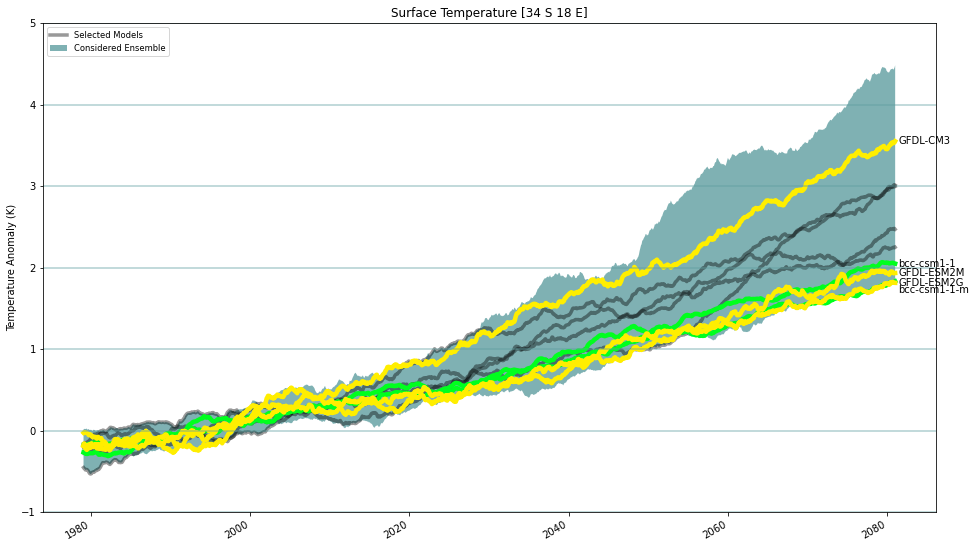

In [14]:
winners = ['MIROC-ESM-CHEM' , 'BNU-ESM' , 'CNRM-CM5' , 'ACCESS1-0']
fam = ['bcc-csm1-1' , 'bcc-csm1-1-m', 'GFDL-ESM2M' , 'GFDL-ESM2G' , 'GFDL-CM3']

fig,ax = plt.subplots(figsize=(16, 9))
for model in winners:
    if model == 'ACCESS1-0':
        selled[model].plot(label = 'Selected Models', color = 'black' , linewidth = 3.5, alpha = 0.4)
    else:
        selled[model].plot(color = 'black' , linewidth = 3.5, alpha = 0.4)
for model in fam:
    selled[model].plot(color = col_dic[model] , linewidth = 4.5) 
    if model == 'bcc-csm1-1-m':
        ax.annotate(xy=(pd.to_datetime('2080/12/30'),selled[model].dropna(dim='time').values[-1]-0.1), xytext=(3,0), textcoords='offset points', text=str(model), va='center',color = 'black')
    else:
        ax.annotate(xy=(pd.to_datetime('2080/12/30'),selled[model].dropna(dim='time').values[-1]), xytext=(3,0), textcoords='offset points', text=str(model), va='center',color = 'black')
x = considered_range
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='cadetblue', alpha=0.8, label = 'Considered Ensemble')   
for x in [-1,0,1,2,3,4, 5]:
    ax.axhline(x,color = 'cadetblue', alpha = 0.5)
ax.set_ylim(-1,5)
plt.legend(loc='upper left', fontsize = 'small')
plt.title('Surface Temperature [34 S 18 E]')
plt.ylabel('Temperature Anomaly (K)')
plt.xlabel('')
plt.savefig('fam_selector.pdf')
plt.show()

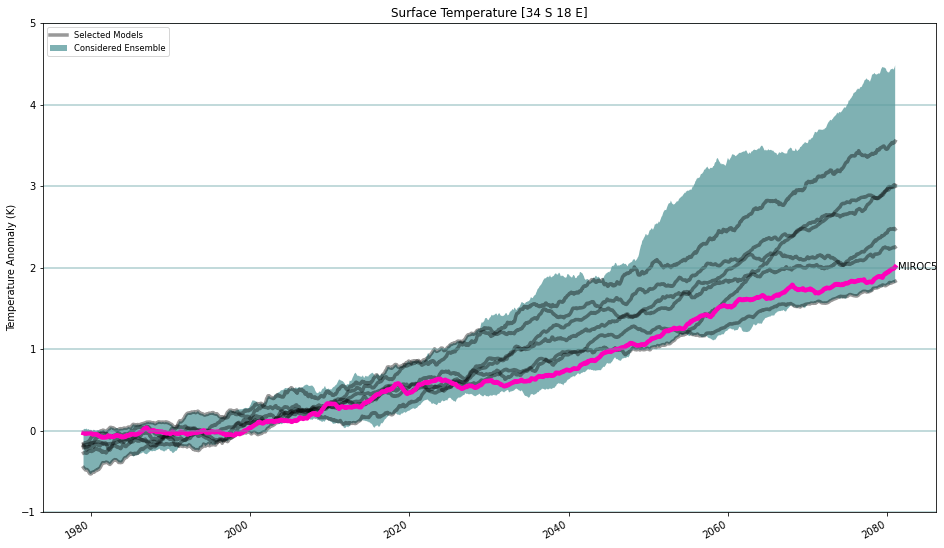

In [15]:
winners = ['MIROC-ESM-CHEM' , 'BNU-ESM' , 'CNRM-CM5' , 'ACCESS1-0', 'GFDL-CM3', 'bcc-csm1-1-m']
fig,ax = plt.subplots(figsize=(16, 9))
for model in winners:
    if model == 'ACCESS1-0':
        selled[model].plot(label = 'Selected Models', color = 'black' , linewidth = 3.5, alpha = 0.4)
    else:
        selled[model].plot(color = 'black' , linewidth = 3.5, alpha = 0.4)

selled['MIROC5'].plot(color = col_dic['MIROC5'] , linewidth = 4.5) 
ax.annotate(xy=(pd.to_datetime('2080/12/30'),selled['MIROC5'].dropna(dim='time').values[-1]), xytext=(3,0), textcoords='offset points', text=str('MIROC5'), va='center',color = 'black')
x = considered_range
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='cadetblue', alpha=0.8, label = 'Considered Ensemble')   
for x in [-1,0,1,2,3,4, 5]:
    ax.axhline(x,color = 'cadetblue', alpha = 0.5)
ax.set_ylim(-1,5)
plt.legend(loc='upper left', fontsize = 'small')
plt.title('Surface Temperature [34 S 18 E]')
plt.ylabel('Temperature Anomaly (K)')
plt.xlabel('')
plt.savefig('MIROC5_selector.pdf')
plt.show()

In [16]:
winners = ['MIROC-ESM-CHEM' , 'BNU-ESM' , 'CNRM-CM5' , 'ACCESS1-0', 'GFDL-CM3', 'bcc-csm1-1-m']


maximum=[]
minimum=[]

for i in range(len(selled['ACCESS1-0'])):
    vals = []
    for model in winners:
        vals.append(selled[model].values[i])
    minimum.append(np.min(vals))
    maximum.append(np.max(vals))
    
winners_range = xr.Dataset(dict(maximum = (["time"], maximum), minimum = (["time"], minimum)) ,coords=dict(time = selled[model].time))

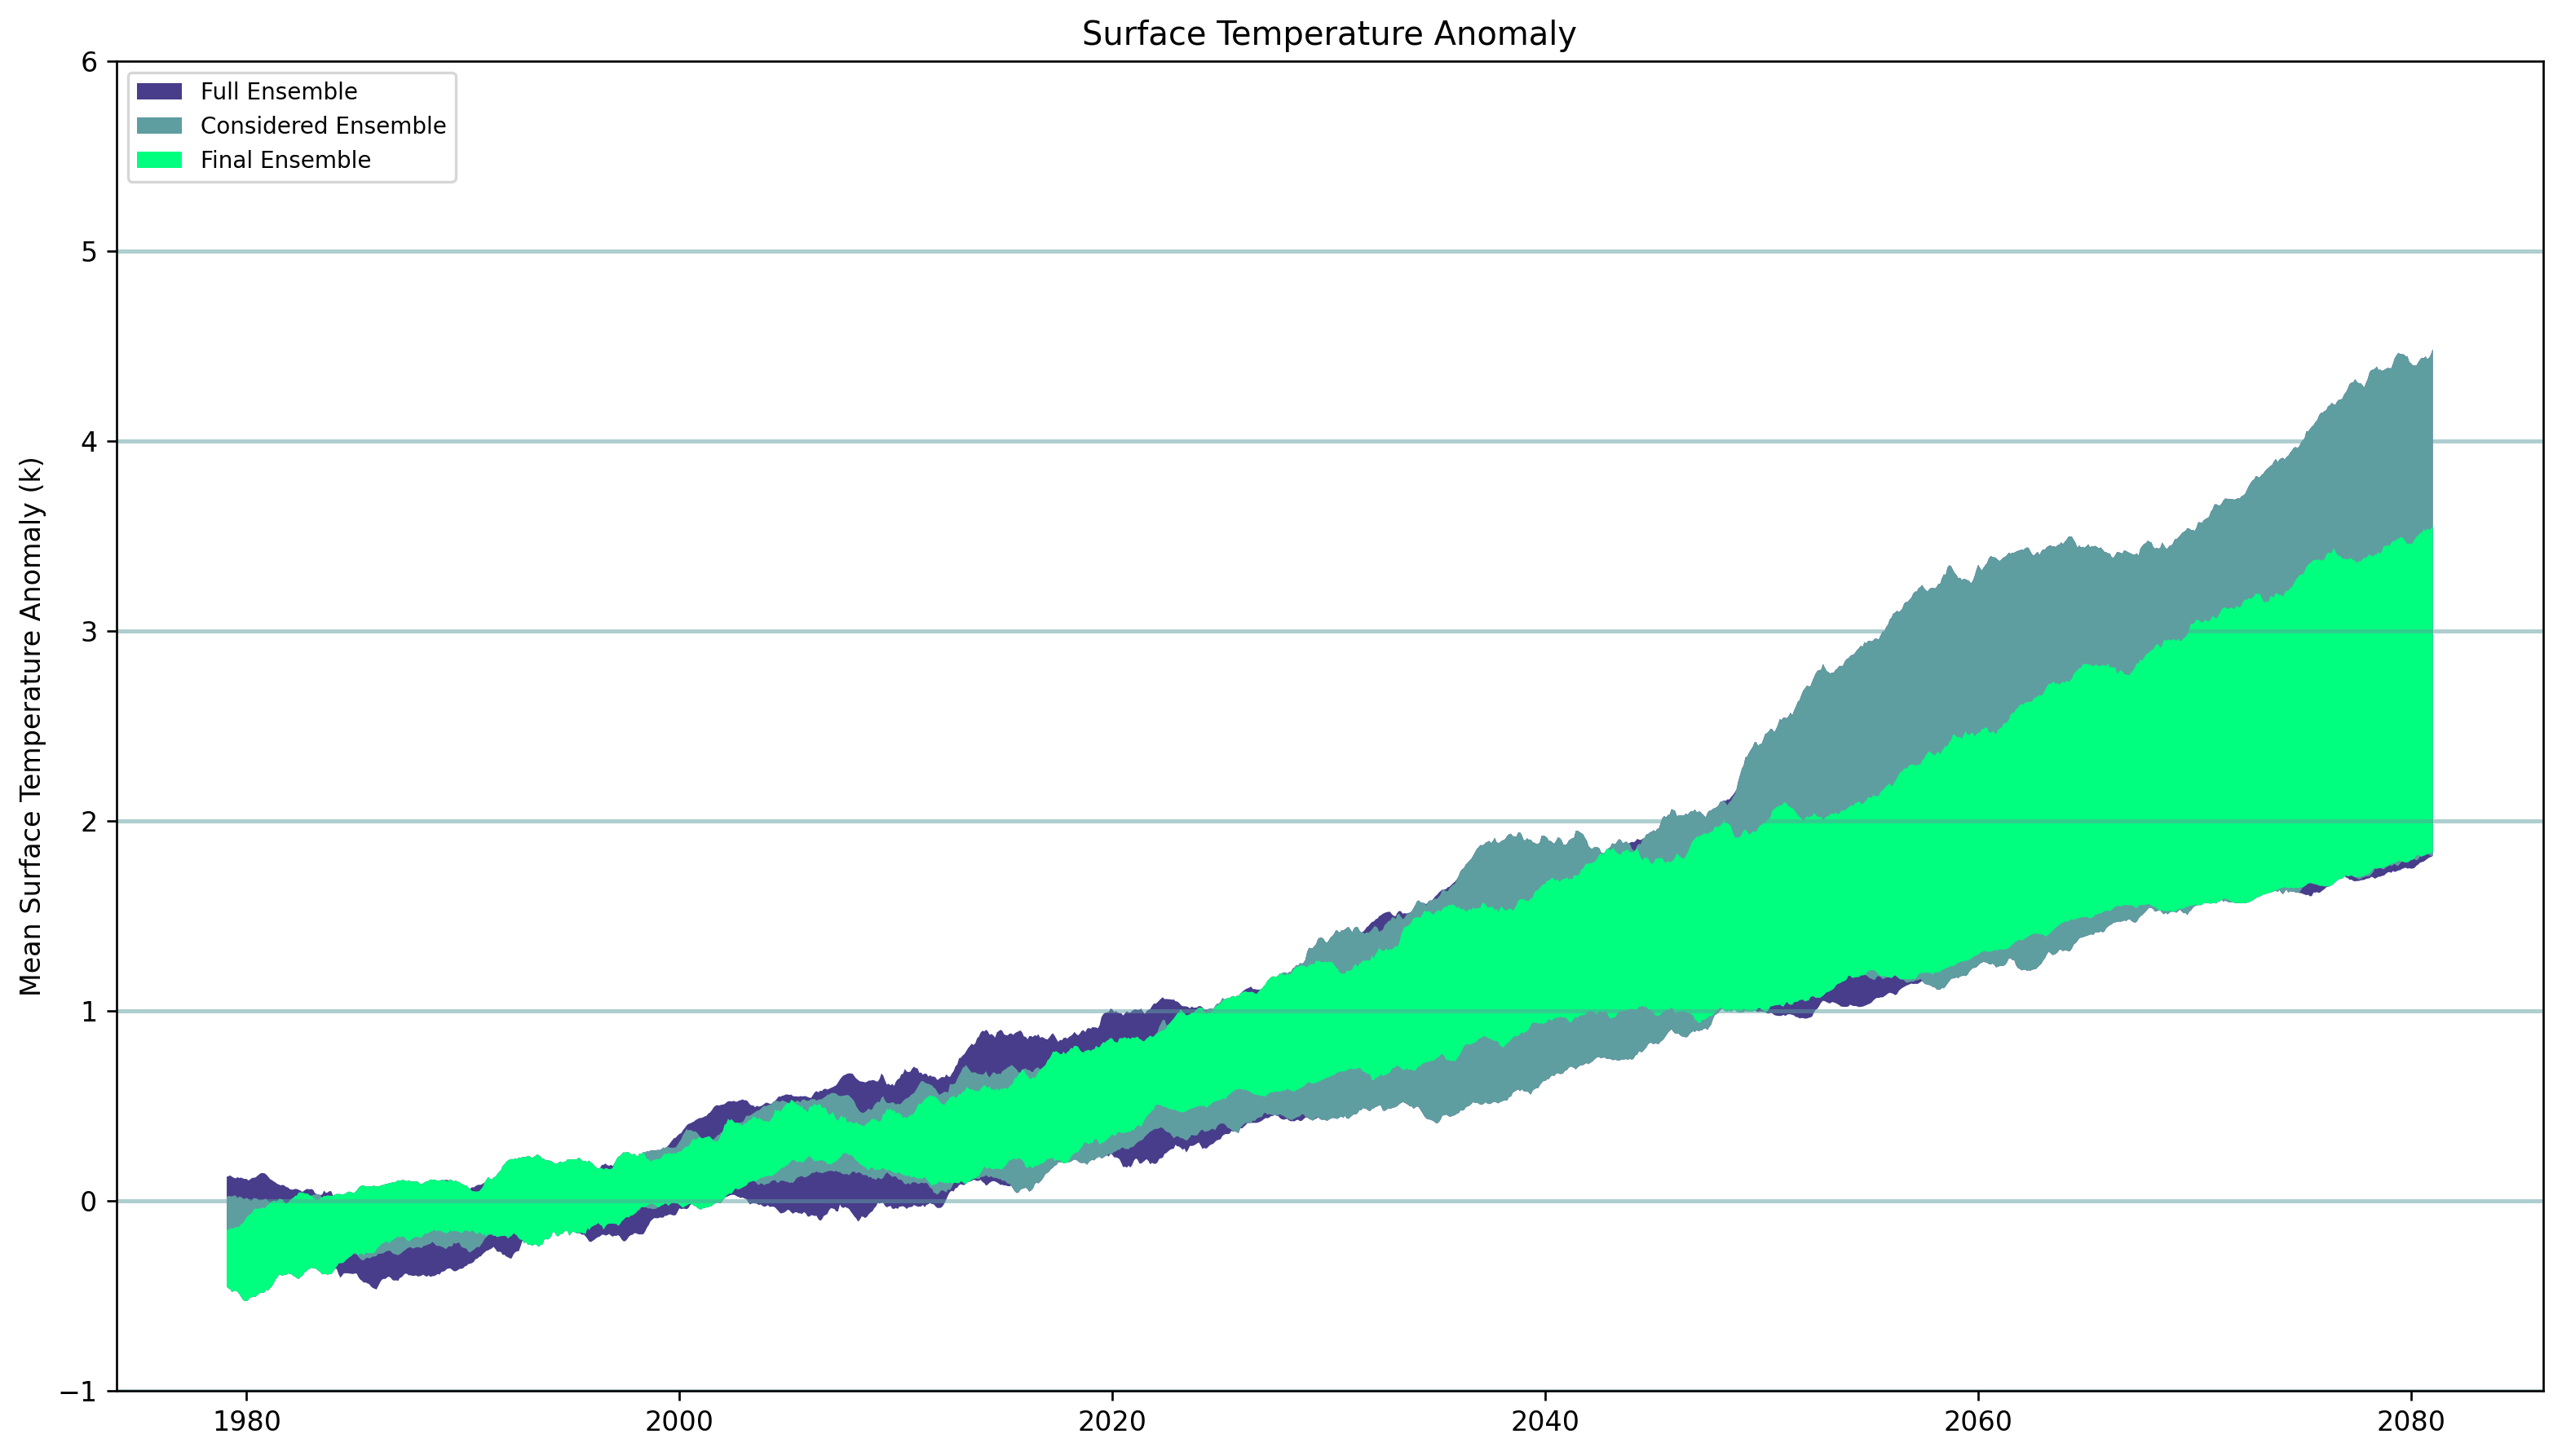

In [17]:
fig,ax = plt.subplots(figsize=(16, 9),dpi = 240)

x = cmip_range
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='darkslateblue', alpha=1, label = 'Full Ensemble')
x = considered_range
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='cadetblue', alpha=1, label = 'Considered Ensemble')
x = winners_range
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='springgreen', alpha=1, label = 'Final Ensemble')     

for x in [-1,0,1,2,3,4, 5]:
    ax.axhline(x,color = 'cadetblue', alpha = 0.5)

plt.ylabel('Mean Surface Temperature Anomaly (k)')
plt.title('Surface Temperature Anomaly')


ax.set_ylim(-1,6)

plt.legend(loc='upper left', fontsize = 'small')
plt.savefig('tas_selected.png',dpi=240)
plt.savefig('tas_selected.pdf')

In [18]:
results_nofront = pd.read_csv('../../scores/results_nofront.csv').set_index('Model')
results_nofront = [model for model in results_nofront.index if model in cmip]

maximum=[]
minimum=[]

for i in range(len(selled['ACCESS1-0'])):
    vals = []
    for model in results_nofront:
        vals.append(selled[model].values[i])
    minimum.append(np.min(vals))
    maximum.append(np.max(vals))
    
considered_range_nofront = xr.Dataset(dict(maximum = (["time"], maximum),minimum = (["time"], minimum)) ,coords=dict(time = selled[model].time))

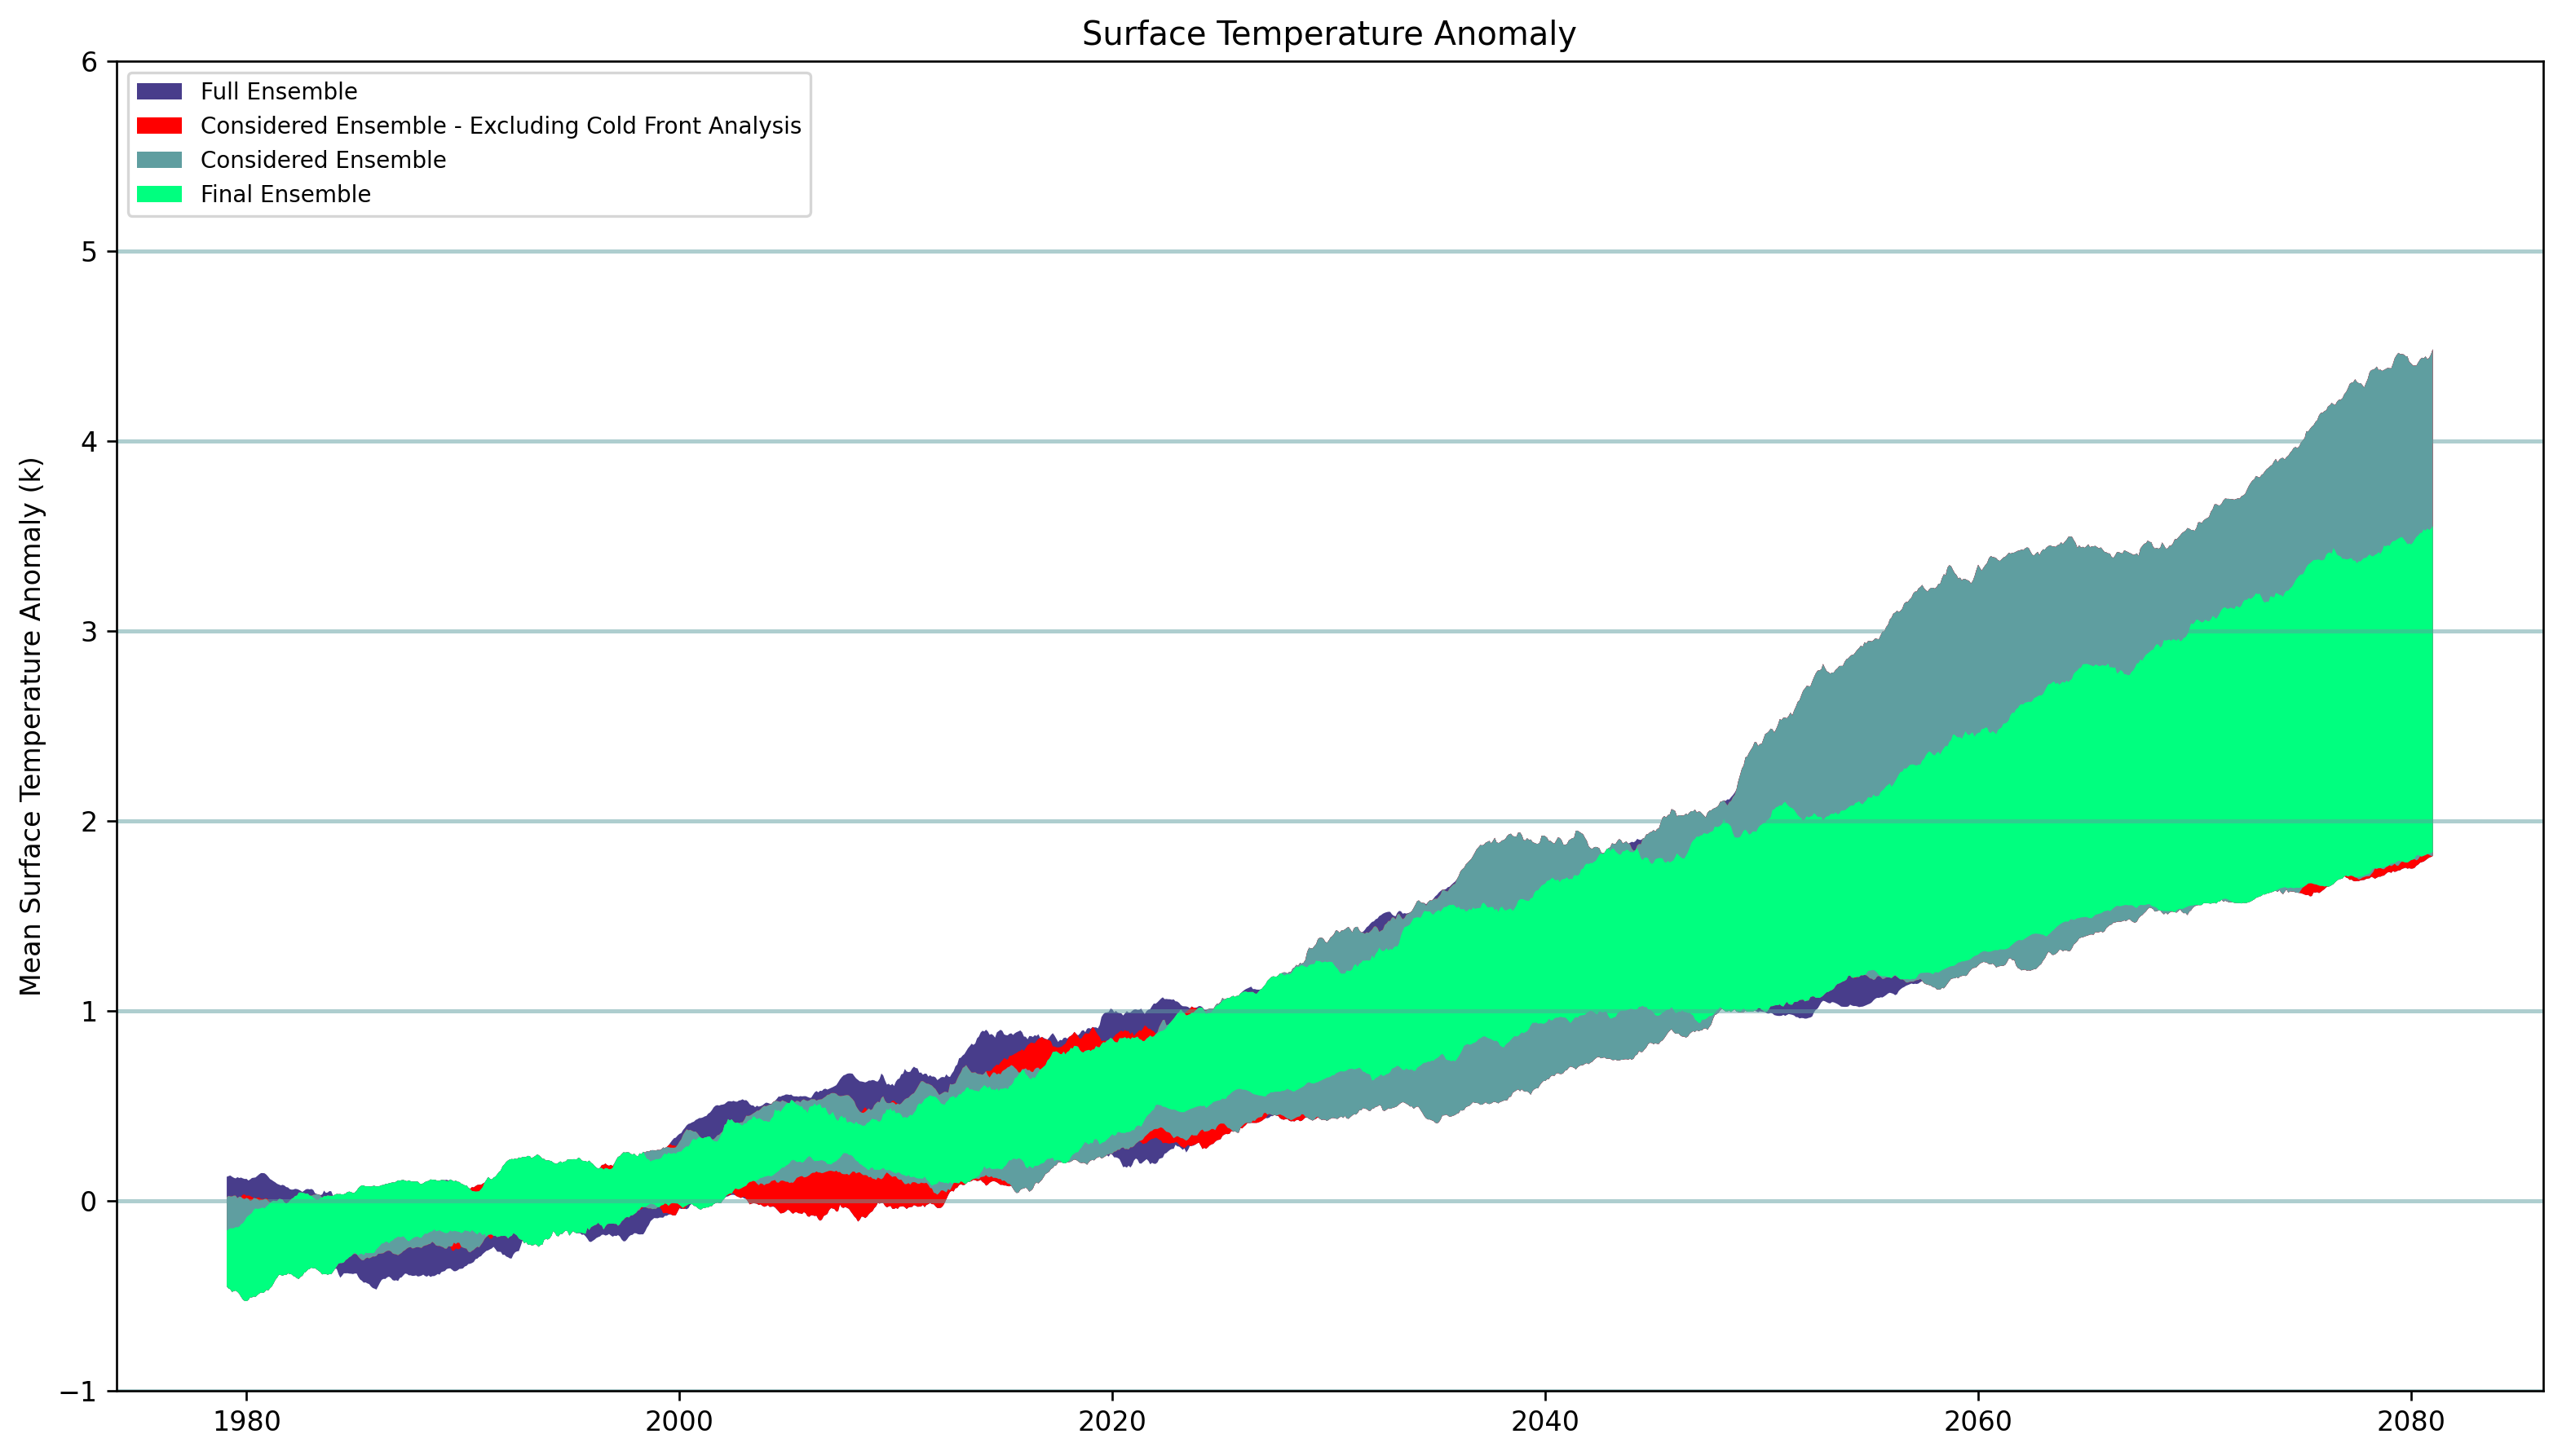

In [20]:
fig,ax = plt.subplots(figsize=(16, 9),dpi = 240)


x = cmip_range
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='darkslateblue', alpha=1, label = 'Full Ensemble')
x = considered_range_nofront
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='red', alpha=1, label = 'Considered Ensemble - Excluding Cold Front Analysis')
x = considered_range
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='cadetblue', alpha=1, label = 'Considered Ensemble')
x = winners_range
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='springgreen', alpha=1, label = 'Final Ensemble')     



for x in [-1,0,1,2,3,4, 5]:
    ax.axhline(x,color = 'cadetblue', alpha = 0.5)

plt.ylabel('Mean Surface Temperature Anomaly (k)')
plt.title('Surface Temperature Anomaly')

ax.set_ylim(-1,6)

plt.legend(loc='upper left', fontsize = 'small')
plt.savefig('tas_selected_nofront.png',dpi=240)
plt.savefig('tas_selected_nofront.pdf')

In [ ]:
""""
#ANIMATION
end = pd.to_datetime('2100/01/01')
counter = 0 
alpha_offset = 0
for end in pd.date_range(start = '1983', end = '2120' , freq='M'):
    fig,ax = plt.subplots(figsize=(16, 9),dpi = 240)
    ax.plot(selled['ERA5'].sel(time = slice ('1950',end)).time, selled['ERA5'].sel(time = slice ('1950',end)).values, color = '#002D52', alpha = 1 , linewidth = 2.8 , label = 'ERA5 Reanalysis')
    ax.plot(selled['NOAA'].sel(time = slice ('1950',end)).time, selled['NOAA'].sel(time = slice ('1950',end)).values, color = '#04015C' , alpha = 1 , linewidth = 3 , label = 'NOAA 20CR Reanalysis')
    if end < pd.to_datetime('2100/01/01'):
        for model in cmip:
            if model in col_dic.keys():
                ax.plot(selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).time, selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).values, color = col_dic[model] , alpha = 1 , linewidth = 4.5)
            else:
                ax.plot(selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).time, selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).values, color = 'grey' , alpha = 0.5 , linewidth = 2)
    elif end < pd.to_datetime('2101/07/01'):
        if alpha_offset < 1:
            alpha_offset = alpha_offset+ 0.05
        for model in cmip:
            if model in col_dic.keys():
                ax.plot(selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).time, selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).values, color = col_dic[model] , alpha = (1 - alpha_offset) , linewidth = 4.5)
            else:
                ax.plot(selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).time, selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).values, color = 'grey' , alpha = (0.5 - (alpha_offset/2)) , linewidth = 2)
    x = cmip_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
    ax.fill_between(x.time, x.minimum,x.maximum, facecolor='steelblue', alpha=1, label = 'Full Ensemble')
    x = considered_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
    ax.fill_between(x.time, x.minimum,x.maximum, facecolor='cadetblue', alpha=1, label = 'Considered Ensemble')
    x = winners_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
    ax.fill_between(x.time, x.minimum,x.maximum, facecolor='springgreen', alpha=1, label = 'Final Ensemble')            
    w = ax.axhline(0 , color = '#00ff1e', label = 'Realistic')
    x = ax.axhline(0 , color = '#ffee00', label = 'Bias')
    y = ax.axhline(0 , color = '#ff1100', label = 'Significant Bias')
    z = ax.axhline(0 , color = '#ff00bb', label = 'Unrealistic')
    zz = ax.axhline(0 , color = 'grey',alpha = 0.5, label = 'Not Assessed')
    plt.legend(loc='upper left', facecolor = 'white')
    w.set_visible(False)
    x.set_visible(False)
    y.set_visible(False)
    z.set_visible(False)
    zz.set_visible(False)
    for x in [-1,0,1,2,3,4, 5]:
            ax.axhline(x,color = 'cadetblue', alpha = 0.5)
    if end < pd.to_datetime('2100/01/01'):
        plt.xlim([pd.to_datetime('1980/01/01'), end + pd.DateOffset(months=24)])
    else:
        plt.xlim([pd.to_datetime('1980/01/01'), pd.to_datetime('2100/01/01')])
    counter = counter+1
    ax.set_ylim(-1,6)
    plt.ylabel('Mean Temperature Anomaly (K)')
    plt.title('Temperature Anomaly')
    plt.savefig('tas_Plots/to_gif'+str(counter)+'png')
    plt.close()
    """